In [4]:
%matplotlib inline
from collections import Counter
import numpy as np
from sklearn import decomposition
from sklearn import manifold
import matplotlib.pyplot as plt
import pandas as pd

Object `work` not found.


In [9]:
def construct_dataframe(spec_donors=[],reject_donors=[],donor_sex=None,donor_age=[],spec_tissues=[],reject_tissues=[],
                       top_tissues=None,min_tissue_count=None):
    #     This function builds a numpy matrix and associated data arrays for the specified
    
    #     --Parameters--
    #     spec_donors: Array of donor ID strings to include. Leave blank for all donors.
    #     reject_donors: Array of donor IDs to remove. Leave blank to reject no donors.
    #     donor_sex: '1' for only males, '2' for only females, None (or blank) for all donors.
    #     donor_age: Array of age-decade strings to include, e.g. ['20','30','40']. Leave blank for all donors.
    #     spec_tissues: Array of tissue names to include. Leave blank for all tissues.
    #     reject_tissues: Array of tissue names to remove. Leave blank to reject no tissues.
    #     top_tissues: Number of most commonly sampled tissues to include. Leave blank to include all tissues.
    #     min_tissue_count: Minimum number of samples to include a tissue. Leave blank to include all tissues.

    #     Note: spec_donors and reject_donors are mutually exclusive.
    #     Note: spec_tissues and reject_tissues are mutually exclusive.
    #     Note: top_tissues and min_tissue_count are mutually exclusive.
    
    #     --Returns--
    #     multi_matrix: Numpy matrix of 10,000 rows, column for each included sample
    #     point_ID: Array of donor IDs for each column in multi_matrix
    #     point_sex: Array of donor sex for each column in multi_matrix
    #     point_age: Array of donor age for each column in multi_matrix
    #     point_tissue: Array of tissue type for each column in multi_matrix
    #     point_tissue_group: Array of tissue group (just first term of tissue type) for each column in multi_matrix

    # DONORS BY ID
    if not spec_donors:
        all_donors = open('../data/donors_list.txt')
        donor_list = [ID[0:-1] for ID in all_donors if ID[0:-1] not in reject_donors]
        all_donors.close()
    else:
        donor_list = spec_donors
    # dictionary of donor IDs, and an array that will be [sex,age]
    donor_dict = dict((ID,[]) for ID in donor_list)

    # DONORS BY AGE AND SEX
    donor_info = open('../data/donor_info.txt')
    for line in donor_info:
        # info is [ID,sex,age,death]
        info = line.split('\t')
        if info[0] in donor_list:
            # check sex
            if donor_sex and info[1] != donor_sex:
                del donor_dict[info[0]]
            else:
                donor_dict[info[0]].append(info[1])
            # check age    
            age = info[2].split('-')[0]
            if donor_age and age not in donor_age:
                del donor_dict[info[0]]
            else:
                donor_dict[info[0]].append(ages[0])
    donor_info.close()

    # TISSUES BY TYPE AND SAMPLE COUNT
    tissues = Counter()
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata/donor_meta_'+ID+'.txt')
        for line in metafile:
            # look for tissue type listed in meta file
            tissue = line.split('\t')[1]
            if spec_tissues and tissue in spec_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
            elif tissue not in reject_tissues:
                tissues[tissue] = tissues.get(tissue,0) + 1
        metafile.close()
    if min_tissue_count:
        tissue_list = [key for key,value in tissues.iteritems() if value >= min_tissue_count]
    else:
        tissue_list = [key for key,value in tissues.most_common(top_tissues)]

    # CONSTRUCT MATRIX
    # initialize column (to be removed) and info types
    multi_matrix = np.zeros((10000,1))
    point_ID = []
    point_sex = []
    point_age = []
    point_tissue = []
    point_tissue_group = []
    # metadata on relevant points
    for ID in donor_dict.keys():
        metafile = open('../data/Donor_Metadata/donor_meta_'+ID+'.txt')
        # column indices for relevant tissues
        columns = []
        column = 0
        for line in metafile:
            tissue = line.split('\t')[1]      
            if tissue in tissue_list:
                columns.append(column)
                point_ID.append(ID)
                point_sex.append(donor_dict[ID][0])
                point_age.append(donor_dict[ID][1])
                point_tissue.append(tissue[0:-1])
                point_tissue_group.append(tissue.split('-')[0])
            column = column + 1
        metafile.close()
        # get data
        donor_matrix = np.zeros((10000,len(columns)))
        row = 0
        donorfile = open('../data/donor_matrices_fixed/donor_'+ID+'.txt')
        for line in donorfile:
            # from file, take desired tissue columns and put in donor matrix
            values = [line.split('\t')[ind] for ind in columns]
            donor_matrix[row,:] = values
            row = row+1
        donorfile.close()
        # concatenate donor matrices
        multi_matrix = np.concatenate((multi_matrix,donor_matrix),axis=1)
    multi_matrix = np.delete(multi_matrix,0,1)
    
    return [multi_matrix, point_ID, point_sex, point_age, point_tissue, point_tissue_group]

In [196]:
# REDUCE DIMENSIONS OF DATA - This stage may take quite a while! PCA ~10 minutes | tSNE ~20 minutes

perform_pca = False
perform_mds = False
perform_tsne = False

# Now, for plotting:
plot_spec_donors = []         # array of specific donor IDs to plot, or None (for any donor ID)
plot_reject_donors = []       # array of donor IDs not to plot - [] if spec_donors or if no rejects
plot_sex = None               # '1' (for male),'2' (for female), or None (for either)
plot_age = []                 # array of age ranges to be plotted, e.g. ['20','30'] - default, all ages
plot_spec_tissues = []        # array of tissues not to plot
plot_reject_tissues = []      # array of specific tissue names (as strings), or None (for any tissue)

if perform_pca:
    pca = decomposition.PCA(n_components=2)
    data_pca = pca.fit_transform(multi_matrix.transpose())
    print 'PCA complete'
    plot_data(data_pca,)

if perform_mds:
    mds = manifold.MDS(n_components=2)
    data_mds = mds.fit_transform(multi_matrix.transpose())
    print 'MDS complete'

if perform_tsne:
    tsne = manifold.TSNE(n_components=2)
    data_tsne = tsne.fit_transform(multi_matrix.transpose())
    print 'tSNE complete'


In [197]:
def plot_data(matrix,spec_donors=None,reject_donors=None,sex=None,age=None,spec_tissues=None,reject_tissues=None,colorby='tissue'):
    # matrix: Input after dimensionality reduction, with two rows of points
    # spec_donors: Array of donor IDs to be plotted - default, all donors
    # reject_donors: Array of donor IDs to be plotted - default, all donors included
    # sex: '1' to plot only males, '2' to plot only females - default, both sexes
    # age: Array of age ranges to be plotted, e.g. ['20','30'] - default, all ages
    # spec_tissues: Array of tissues to plot - default, all tissues
    # reject_tissues: Array of tissues not to plot - default, plot all tissues
    # colorby: Color points according to 'tissues', 'sex', 'age', or 'group' for GO tissue group - default 'tissues'
    
    df = pd.DataFrame(matrix,columns=['DIM1','DIM2'])
    df['ID'] = point_ID
    df['sex'] = point_sex
    df['age'] = point_age
    df['tissue'] = point_tissue
    
    remove = []
    # if specific donors selected
    for ind,row in df.iterrows():
        if plot_spec_donors:
            if row['ID'] not in plot_spec_donors:
                remove.append(ind)
                continue
        elif plot_reject_donors:
            if row['ID'] in plot_reject_donors:
                remove.append(ind)
                continue
        
        if sex:
            if row['sex'] != sex:
                remove.append(ind)
                continue
        
        if age:
            if row['age'] not in age:
                remove.append(ind)
                continue
        
        if plot_spec_tissues:
            if row['tissue'] not in plot_spec_tissues:
                remove.append(ind)
                continue
        elif plot_reject_tissues:
            if row['tissue'] in plot_reject_tissues:
                remove.append(ind)
    
    df = df.drop(df.index[remove])
    
    labels = set(df[colorby])
    jet = plt.get_cmap('jet')
    colors = jet(np.linspace(0, 1, len(labels)))
    color = 0
    
    fig, ax = plt.subplots(figsize = (10,10))
    for i,group in df.groupby(colorby):
        group.plot(x='DIM1',y='DIM2',kind='scatter',label=i,color=colors[color],ax=ax)
        color = color + 1
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

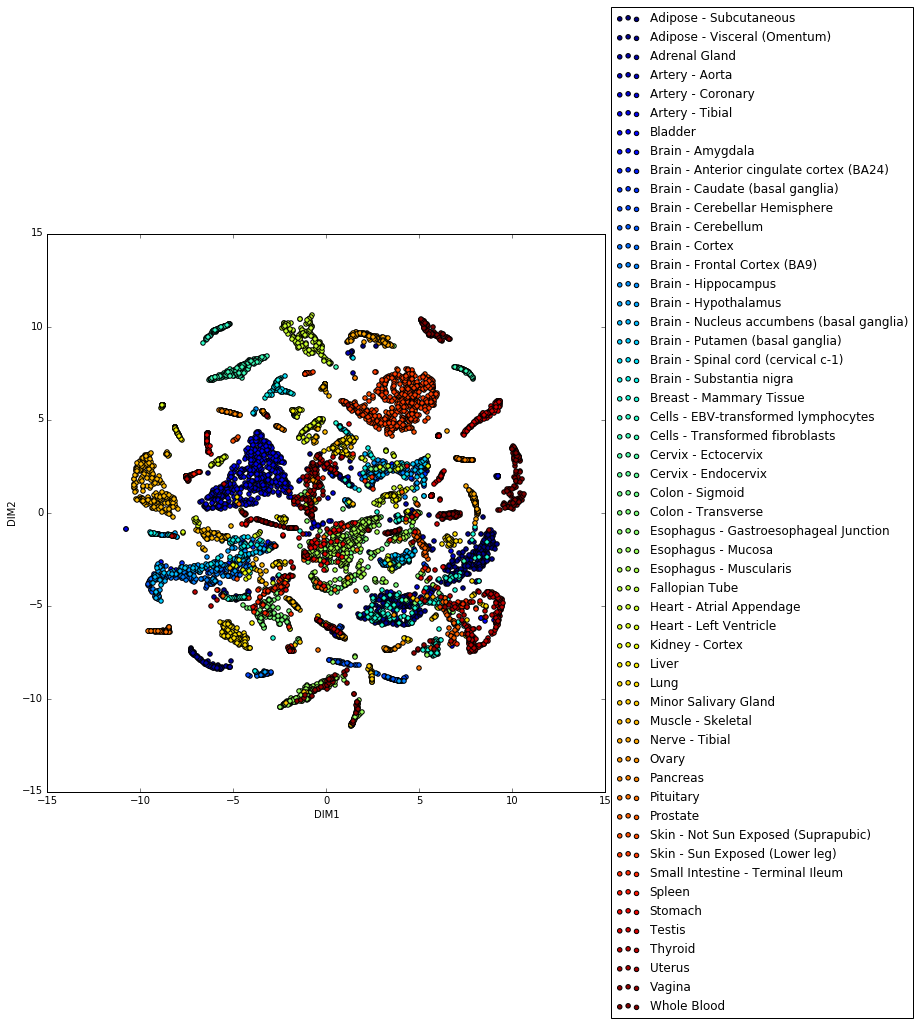

In [198]:


plot_data(data_tsne, spec_donors = plot_spec_donors, sex = plot_sex, age = plot_age)